In [1]:
import ATARI.syndat as syndat
import ATARI
import os
import numpy as np
from matplotlib.pyplot import *
# import nuctools as nuc
import pandas as pd
import scipy.linalg as spla

In [2]:
%matplotlib widget

## The purpose of this notebook is to verify the methodology and execution thereof in the Syndat code

This is done in two primary ways.

First, the real data used in Brown, et al. will be put through the reduction part of the syndat code. This will allow for a 1 to 1 comparison with the reduction performed in the reference and will verify that the execution of the reduction methodology in the Syndat code is being properly executed.

Second, the novel methodology behind Syndat will be heuristically verified. This novel methodology is th inversion of the reduction process in order to synthetically generate experimental data from a theoretically "true" cross section. This verification because difficult becuase the "true" cross section in nature that generated the real/observed experimental data is inaccessible. Therefore, the "best guess" of the true cross section is assumed to have generated the observed data. That best guess can then be used to generate synthetic experimental data that can be heuristically compared to the observed data.

### Import/interogate the data from Jesse's reduction

The csv read in comes from Brown, et al., this is a reduction of transmission data from RPI. 

This first section of code can be used to pull/write the observed data I have access to, or other simple investigations of observed data.

In [3]:
# import Jesse's reduced data and look at it
jb_df = pd.read_csv("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/JB_reduction_data.csv", index_col='Unnamed: 0')
jb_cov = np.load("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/JB_cov.npy")
jb_sys = np.load("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/JB_syst.npy")
jb_stat = np.load("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/JB_stat.npy")
jb_df['bw'] = jb_df.bw*1e-6

plotting = False


In [4]:
np.unique(jb_df['bw']*1e6)

array([0.0256, 0.0256, 0.0256, 0.0256, 0.0256, 0.0256, 0.0256, 0.0256,
       0.1024, 0.1024, 0.1024, 0.1024, 0.8192, 0.8192, 0.8192, 0.8192,
       0.8192, 0.8192, 0.8192, 0.8192])

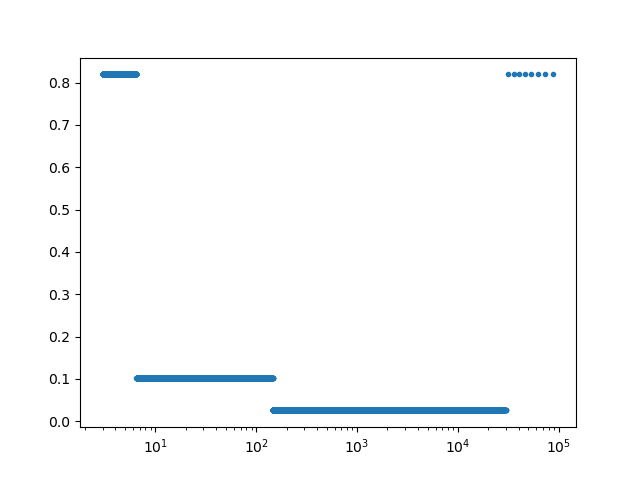

In [5]:
figure()
plot(jb_df.e, jb_df['bw']*1e6, '.')
xscale('log')

In [6]:
jb_df[(jb_df.e>3)&(jb_df.e<2550)]

,e,trans,tof,bw,cs,dcs,cts,dcts,bs,dbs,co,dco,cto,dcto,bo,dbo,bfit
1402,2547.605073,0.509648,53.7248,2.560000e-08,1280.305289,52.027318,605.569800,24.608328,30.528396,0.1,2519.535407,100.425422,629.43893,25.088622,67.297637,0.1,3.664013e+01
1403,2545.018928,0.466529,53.7504,2.560000e-08,1189.446650,50.147253,562.594700,23.719079,30.501219,0.1,2551.413044,101.058726,637.40271,25.246836,67.226630,0.1,3.659186e+01
1404,2542.436719,0.406465,53.7760,2.560000e-08,1022.854684,46.503071,483.798600,21.995422,30.474077,0.1,2508.648197,100.208212,626.71905,25.034357,67.155716,0.1,3.654365e+01
1405,2539.858439,0.264870,53.8016,2.560000e-08,657.707571,37.289889,311.088180,17.637692,30.446972,0.1,2435.263401,98.731652,608.38581,24.665478,67.084895,0.1,3.649551e+01
1406,2537.284077,0.340409,53.8272,2.560000e-08,850.123711,42.395106,402.098820,20.052402,30.419902,0.1,2475.010517,99.534115,618.31557,24.865952,67.014168,0.1,3.644743e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15910,3.015622,0.417764,1468.1888,8.192000e-07,18.485957,1.105149,279.796699,16.727125,9.900000,0.1,33.952195,2.060831,271.42570,16.475002,13.400000,0.1,8.506101e-31
15911,3.012251,0.349083,1469.0080,8.192000e-07,17.332079,1.070102,262.332019,16.196667,9.900000,0.1,34.690271,2.083110,277.32614,16.653112,13.400000,0.1,8.154724e-31
15912,3.008887,0.297559,1469.8272,8.192000e-07,15.890513,1.024634,240.513011,15.508482,9.900000,0.1,33.532182,2.048044,268.06797,16.372781,13.400000,0.1,7.817863e-31
15913,3.005528,0.500051,1470.6464,8.192000e-07,18.931344,1.118383,286.537910,16.927431,9.900000,0.1,31.460858,1.983781,251.50908,15.859038,13.400000,0.1,7.494916e-31


In [7]:

## we have slightly different constants for the mass of a neutron!!!! - calculate theoretical cross section using my energy grid in order to have alignment
# # print(syndat.exp_effects.t_to_e((11.8816-3.326)*1e-6, 35.185, True) )
# mnc2 = 939565413.3  # NIST neutron mass [eV]
# c = 299.792458    
# print(mnc2*(1/np.sqrt(1-( 35.185/(11.8816-3.326)/c)**2)-1))
# mn = 939.56542052e6 # eV/c2
# c = 299792458 # m/s
# print(mn*(1/np.sqrt(1-(d/t/c)**2)-1))
# syndat.sammy_interface.write_estruct_file(np.array(jb_df.e), "/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JEFF_eval/estruct_rpi_open")


In [8]:
len(jb_df.e)
print(np.unique(jb_df['bw']*1e6))


[0.0256 0.0256 0.0256 0.0256 0.0256 0.0256 0.0256 0.0256 0.1024 0.1024
 0.1024 0.1024 0.8192 0.8192 0.8192 0.8192 0.8192 0.8192 0.8192 0.8192]


In [9]:
from ATARI.sammy_interface import sammy_functions
jeff_eval = sammy_functions.readlst("/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JEFF_eval/SAMMY.LST")


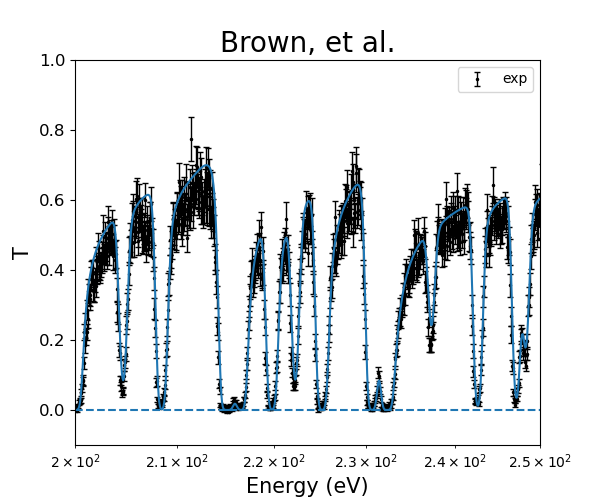

In [10]:
fig = figure(figsize=(6,5))

errorbar(jb_df.e, jb_df.trans, yerr=np.sqrt(np.diag(jb_cov)), color='k',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3, zorder=1, label='exp')
# errorbar(jb_df.tof, jb_df.trans, yerr=np.sqrt(np.diag(jb_cov)), color='k',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3, zorder=1, label='exp')
plot(jeff_eval.E, jeff_eval.theo_trans)
axhline(y=0.0, ls='--')
ylim([-0.1,1])
xlim([200,250])
xscale('log')
# scatter(jb_df[np.isclose(jb_df['bw']*1e6,0.0256)].e, [0.9]*len(jb_df[np.isclose(jb_df['bw']*1e6,0.0256)].e), color='r')
# scatter(jb_df[np.isclose(jb_df['bw']*1e6,0.1024)].e, [0.9]*len(jb_df[np.isclose(jb_df['bw']*1e6,0.1024)].e), color='b')

title('Brown, et al.', fontsize=20)
legend(loc='upper right')
# xlabel('ToF ($\mu s$)', fontsize=15)
xlabel('Energy (eV)', fontsize=15)

ylabel('T', fontsize=15)
xticks(fontsize=12)
yticks(fontsize=12)
legend()

In [11]:
# figure()
# plot(jb_df.e, jb_df.cs)
# yscale('log')
# xscale('log')

# transmission_data = jb_df.rename(columns={'e':'E', 'trans':'exp_trans'})
# transmission_data['exp_trans_unc'] = np.sqrt(np.diag(jb_cov))
# # transmission_data
# syndat.sammy_interface.write_samdat(transmission_data, '/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JEFF_GLLS_410_580_nTOF/observed.dat')

In [13]:
# t0 = 3.326e-6  # s
# FP = 35.185 # m
# experimental_bin_width = 6.4e-9 # s

# E_min_max = [min(jb_df.e), max(jb_df.e)]
# tof_min_max = syndat.exp_effects.e_to_t(np.array(E_min_max),FP, True)+t0
# tof_grid = np.arange(min(tof_min_max), max(tof_min_max), experimental_bin_width)
# energy_grid = syndat.exp_effects.t_to_e(tof_grid,FP,True)

# # SAMMY Resolution function input for raw bin width
# # print(nuctools.funky.two(syndat.exp_effects.t_to_e(min(tof_min_max)-t0,FP, True)), experimental_bin_width*1e9, 0.8)

# # syndat.sammy_interface.write_estruct_file(energy_grid, "/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JEFF_eval/exp_energy_grid")

# 
t0 = 3.326e-6  # s
FP = 35.185 # m

# emin = syndat.exp_effects.t_to_e(214*1e-6+t0,FP, True)
# emax = syndat.exp_effects.t_to_e(1000*1e-6+t0,FP, True)

# print(emin,emax)

In [ ]:
opendata = '/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/rpi-open-ta181.csv'
# sammy_xs = "/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JEFF_eval/SAMMY_gfactor16.LST"
# sammy_xs = "/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JEFF_eval/SAMMY_rebinnedestruct.LST"
sammy_xs = "/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JEFF_GLLS_410_580_nTOF/SAMMY.LST"
# sammy_xs = "/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JEFF_GLLS_410_580_nTOF/SAMMY.LST"
JEFF = ATARI.sammy_functions.readlst(sammy_xs)
theo = JEFF.loc[:,['E', 'theo_trans_bayes', 'theo_xs_bayes']]
theo.rename(columns={'theo_trans_bayes':'theo_trans', 'theo_xs_bayes':'theo_xs'}, inplace=True)
theo['tof'] = syndat.exp_effects.e_to_t(theo.E,35.185, True)*1e6+3.326
emin = 19.01726591
emax = 37.87784912
# filter theoretical because exp.run() will take energy domain from theoretical df
theo = theo[(theo.E>emin)&(theo.E<emax)] 
# jb_df = jb_df[(jb_df.e>emin) & (jb_df.e<emax)]

options =  {'Add Noise':True, 
            'Sample TURP':True,
            'Sample TOCS':True,
            'Calculate Covariance':True,
            'Compression Points':[],
            'Grouping Factors': None ,
            'Smooth Open Spectrum':False } 
# redpar = {'n': {'val':0.067166,    'unc'   :   0}}

exp = syndat.experiment(energy_domain=None,  
                        experiment_parameters={},
                        input_options = options)
                        
# exp.get_bkg()
# exp.sdat = jb_df.filter(['e','tof', 'bw', 'cts', 'dcts'])
# exp.sdat.rename(columns={"e": "E", "cts": "c", "dcts": "dc"}, inplace=True)

AttributeError: module 'ATARI.syndat' has no attribute 'sammy_functions'

In [ ]:
exp.run(theo, open_data=opendata)

In [ ]:
theo_cps, unc = syndat.exp_effects.cts_to_ctr(exp.theo_c, np.sqrt(exp.theo_c), exp.odat.bw, exp.redpar.val.trigs)


In [ ]:
# put eveything in a similarly structured dataframe
syndat_df = pd.DataFrame({
    'e' :       exp.odat.E,
    'trans':    exp.trans.exp_trans,
    # 'theo':     theo.theo_trans,
    'tof':      exp.trans.tof,
    'cs' :      exp.sdat.cps,
    # 'theo_cts': exp.sdat.theo_cts,
    'cts':      exp.sdat.c,
    'dcs':      exp.sdat.dcps,
    'bs' :      exp.redpar.val.ks*exp.Bi+exp.redpar.val.b0s,
    'dbs':      np.array([0.1]*len(exp.odat.E)),
    'co' :      exp.odat.cps,
    'dco':      exp.odat.dcps,
    'bo' :      exp.redpar.val.ko*exp.Bi+exp.redpar.val.b0o,
    'dbo': np.array([0.1]*len(exp.odat.E))
    # 'bfit': exp_f(trans1.open_data.tof,A,B)
})
syndat_df= syndat_df[::-1].reset_index(drop=True)
eLimits = (3,100000)
syndat_df = syndat_df[(syndat_df.e>eLimits[0])&(syndat_df.e<eLimits[1])].reset_index(drop=True)
syndat_df.sort_values('tof', inplace=True)
display(syndat_df)


,e,trans,tof,cs,cts,dcs,bs,dbs,co,dco,bo,dbo
1659,37.870079,0.185020,416.694401,113.321446,214.399006,7.739283,9.9,0.1,572.374850,23.932811,13.4,0.1
1658,37.851324,0.195961,416.796804,108.317489,204.931749,7.566481,9.9,0.1,515.629327,22.715497,13.4,0.1
1657,37.832582,0.177775,416.899201,114.962010,217.502878,7.795103,9.9,0.1,604.382229,24.592874,13.4,0.1
1656,37.813855,0.176895,417.001602,104.200364,197.142335,7.421288,9.9,0.1,546.486003,23.385301,13.4,0.1
1655,37.795141,0.233914,417.103999,139.531987,263.988155,8.587793,9.9,0.1,567.586017,23.832482,13.4,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...
4,19.048968,0.684629,586.166400,242.026409,457.902926,11.310350,9.9,0.1,352.454418,18.780403,13.4,0.1
3,19.042276,0.627445,586.268805,214.312573,405.469611,10.643109,9.9,0.1,339.185756,18.423504,13.4,0.1
2,19.035588,0.672858,586.371201,240.496878,455.009123,11.274555,9.9,0.1,356.112562,18.877613,13.4,0.1
1,19.028903,0.586987,586.473606,189.817406,359.125872,10.016424,9.9,0.1,319.909970,17.892348,13.4,0.1


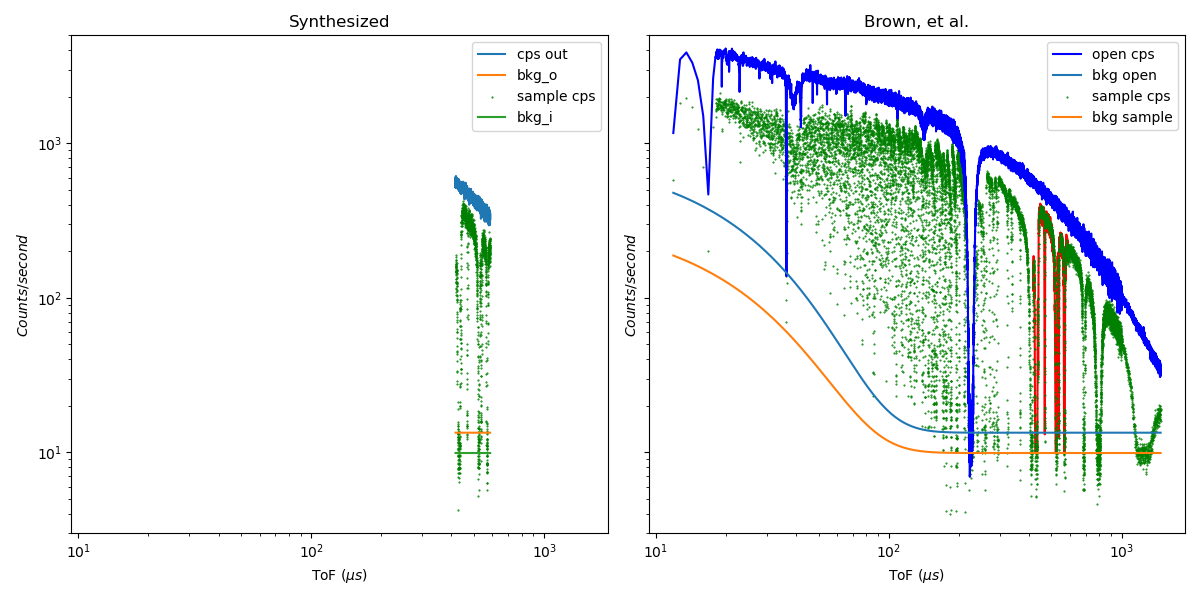

In [ ]:
fig, ax = subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

ax[0].plot(syndat_df.tof,syndat_df.co, label='cps out'); 
ax[0].plot(syndat_df.tof, syndat_df.bo, label='bkg_o')

# ax[0].plot(syndat_df.tof, theo_cps, zorder=1, color='r')
# ax[0].plot(jb_df.tof,jb_df.co, zorder=0, label='open cps', color='b'); 

ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].scatter(syndat_df.tof,syndat_df.cs,marker='.', s=1, label='sample cps', color='g')
# ax[0].scatter(syndat_df.tof,syndat_df.theo_cts,marker='.', s=2, label='theo cts', color='k')
ax[0].plot(syndat_df.tof, syndat_df.bs, label='bkg_i')

ax[0].set_ylim([3,5e3])
# ax[0].set_xlim([250,1.5e3])

ax[0].set_title("Synthesized")
ax[0].legend(loc='upper right')
ax[0].set_xlabel('ToF ($\mu s$)')
ax[0].set_ylabel('$Counts/second$')


ax[1].plot(syndat_df.tof, theo_cps, zorder=1, color='r')
ax[1].plot(jb_df.tof,jb_df.co, label='open cps', color='b'); 
ax[1].plot(jb_df.tof, jb_df.bo, label='bkg open')
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].scatter(jb_df.tof,jb_df.cs,marker='.', s=1, label='sample cps', color='g'); 
ax[1].plot(jb_df.tof, jb_df.bs, label='bkg sample')

ax[1].set_ylim([3,5e3])
# ax[1].set_xlim([250,1.5e3])

ax[1].set_title("Brown, et al.")
ax[1].legend(loc='upper right')
ax[1].set_xlabel('ToF ($\mu s$)')
ax[1].set_ylabel('$Counts/second$')

tight_layout()

### The reason it seems like there's more noise than in the observed data
This is driven by the open count rate, even when we do not sample a new realization of it. Becuase in actuallity, there is some average open count rate that is smoother than the estimate we have measured. That true open count rate results in a true expected count rate that is smooth, then noise is sampled around that. To visualize this, run an experiment with an approximated count rate and set the option 'Smooth Open Spectrum' to True. Now set it to False and look at the difference.

In [ ]:

# exp.run(sammy_xs, open_data=opendata)
# sample2 = exp.trans

# exp.run(sammy_xs, open_data=opendata)
# sample3 = exp.trans

In [ ]:
# JEFF = syndat.sammy_interface.readlst('/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JEFF_GLLS_410_580_nTOF/SAMMY_JEFF.LST')
# JEFF = syndat.sammy_interface.readlst('/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JEFF_eval/SAMMY.LST')

tof_jeff = syndat.exp_effects.e_to_t(JEFF.E, exp.redpar.val.FP,True)*1e6+exp.redpar.val.t0
# JEFF|

In [ ]:
new_jeff = syndat.sammy_interface.readlst('/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JEFF_GLLS_410_580_nTOF/SAMMY.LST')
tof_new_jeff = syndat.exp_effects.e_to_t(new_jeff.E, exp.redpar.val.FP,True)*1e6+exp.redpar.val.t0

# print(sum((np.array(JEFF.theo_trans)-np.array(jb_df.trans[(jb_df.tof<=max(tof_jeff)+1e-3)&(jb_df.tof>=min(tof_jeff)-1e-3)]))**2))
print(sum((np.array(new_jeff.theo_trans)-np.array(jb_df.trans[(jb_df.tof<=max(tof_new_jeff)+1e-3)&(jb_df.tof>=min(tof_new_jeff)-1e-3)]))**2))
print(sum((np.array(new_jeff.theo_trans_bayes)-np.array(jb_df.trans[(jb_df.tof<=max(tof_new_jeff)+1e-3)&(jb_df.tof>=min(tof_new_jeff)-1e-3)]))**2))
# print(tof)
# print(len(JEFF.theo_trans))
# len(jb_df.tof[(jb_df.tof<=max(tof)+1e-3)&(jb_df.tof>=min(tof)-1e-3)])
emin,emax =syndat.exp_effects.t_to_e((np.array([495, 577])-exp.redpar.val.t0)*1e-6,exp.redpar.val.FP,True )
print(emin,emax)

284.67914422142746
266.9660430463103
26.768021182262725 19.662575877960474


In [ ]:
# figure()

# plot(tof_jeff, JEFF.theo_trans, c='g', label='theo')
# # plot(tof_new_jeff, new_jeff.theo_trans, c='b', label='prior')
# # plot(tof_new_jeff, new_jeff.theo_trans_bayes, c='r', label='posterior')


# errorbar(jb_df.tof, jb_df.trans, yerr=np.sqrt(np.diag(jb_cov)), color='k',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3, zorder=1, label='exp')
# axhline(y=0.0, ls='--')
# ylim([-0.1,1])
# # set_xlim([19.017265912486543, 37.877849118079666 ])
# # xlim([495,577])
# title('Brown, et al.')
# # legend(loc='upper right')
# # set_xlabel('ToF ($\mu s$)')
# ylabel('Trans')
# legend()

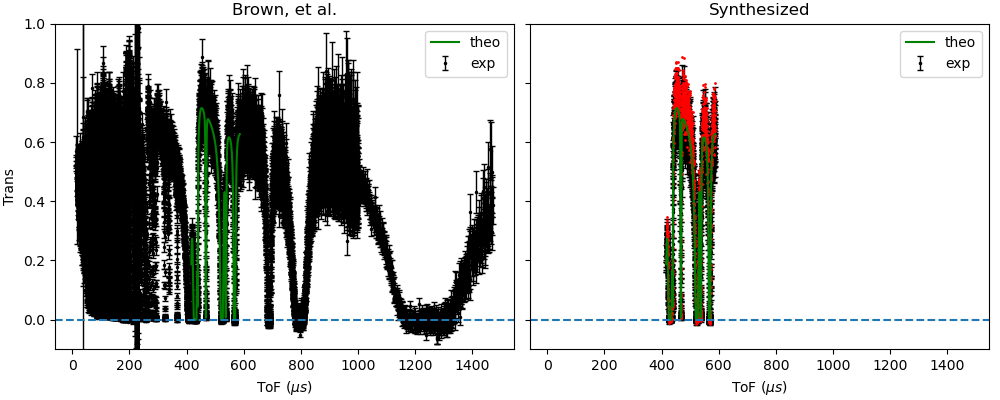

In [ ]:
fig,ax = subplots(1,2, figsize=(10,4), sharex=True, sharey=True)

ax[0].plot(theo.tof, theo.theo_trans, c='g', label='theo')
ax[0].errorbar(jb_df.tof, jb_df.trans, yerr=np.sqrt(np.diag(jb_cov)), color='k',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3, zorder=1, label='exp')
ax[0].axhline(y=0.0, ls='--')
ax[0].set_ylim([-0.1,1])
# ax[0].set_xlim([416,579])
# ax[0,0].set_xlim([19.017265912486543, 37.877849118079666 ])
# ax[0,0].set_xlim([410,580])
ax[0].set_title('Brown, et al.')
# ax[0,0].legend(loc='upper right')
ax[0].set_xlabel('ToF ($\mu s$)')
ax[0].set_ylabel('Trans')
ax[0].legend()


# syndat 1
ax[1].errorbar(syndat_df.tof, syndat_df.trans, yerr=np.sqrt(np.diag(exp.CovT)), color='k',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3, zorder=1, label='exp')
# ax[1].errorbar(syndat_df.tof, syndat_df.trans*1.1, yerr=np.sqrt(np.diag(exp.CovT)), color='',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3, zorder=1, label='exp')
ax[1].plot(syndat_df.tof, syndat_df.trans*1.1, 'r.', ms=2)
# ax[1].plot(syndat_df.tof, syndat_df.trans, 'k.', ms=2)
ax[1].plot(theo.tof, theo.theo_trans, c='g', label='theo')
ax[1].axhline(y=0.0, ls='--')
ax[1].set_ylim([-0.1,1])
# ax[1].set_xlim([416,579])
ax[1].set_title('Synthesized')
# ax[1,0].legend(loc='upper right')
ax[1].set_xlabel('ToF ($\mu s$)')
# ax[1].set_ylabel('Trans')
ax[1].legend()

# # syndat 2
# ax[1,1].errorbar(sample2.tof, sample2.exp_trans, yerr=sample2.exp_trans_unc, color='k',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3, zorder=1, label='exp')
# ax[1,1].plot(theo.tof, theo.theo_trans, c='g', label='theo')
# ax[1,1].axhline(y=0.0, ls='--')
# ax[1,1].set_ylim([-0.1,1])
# ax[1,1].set_xlim([410,580])
# ax[1,1].set_title('Synthesized')
# # ax[1,1].legend(loc='upper right')
# ax[1,1].set_xlabel('ToF ($\mu s$)')
# # ax[1,1].set_ylabel('Trans')
# # ax[1,1].legend()

# # Syndat 3
# ax[0,1].errorbar(sample3.tof, sample3.exp_trans, yerr=sample3.exp_trans_unc, color='k',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3, zorder=1, label='exp')
# ax[0,1].plot(theo.tof, theo.theo_trans, c='g', label='theo')
# ax[0,1].axhline(y=0.0, ls='--')
# ax[0,1].set_ylim([-0.1,1])
# ax[0,1].set_xlim([410,580])
# ax[0,1].set_title('Synthesized')
# # ax[0,1].legend(loc='upper right')
# # ax[0,1].set_xlabel('ToF ($\mu s$)')
# # ax[0,1].set_ylabel('Trans')
# # ax[0,1].legend()

# handles, labels = ax[0,1].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center')
tight_layout(pad=0.25)

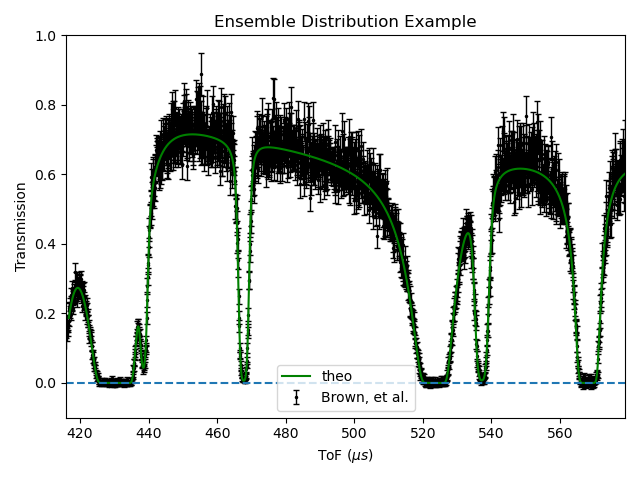

In [ ]:
figure()

plot(theo.tof, theo.theo_trans, c='g', label='theo')
errorbar(jb_df.tof, jb_df.trans, yerr=np.sqrt(np.diag(jb_cov)), color='k',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3, zorder=1, label='Brown, et al.')

# errorbar(syndat_df.tof, syndat_df.trans, yerr=np.sqrt(np.diag(exp.CovT)), color='k',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3, zorder=1, label='Synthetic')
# errorbar(syndat_df.tof, syndat_df.trans*1.1, yerr=np.sqrt(np.diag(exp.CovT)), color='',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3, zorder=1, label='exp')
# plot(syndat_df.tof, syndat_df.trans*1.1, 'r.', ms=3,alpha=1, label="Synthetic Realization")
# plot(syndat_df.tof, syndat_df.trans*0.9, 'b.', ms=3, alpha=1,label="Synthetic Realization")
# plot(syndat_df.tof, syndat_df.trans, 'g.', ms=3, alpha=1.0, label="Synthetic Realization")
# plot(syndat_df.tof, syndat_df.trans, 'k.', ms=2)

axhline(y=0.0, ls='--')
ylim([-0.1,1])
xlim([416,579])
title('Ensemble Distribution Example')
xlabel('ToF ($\mu s$)')
ylabel("Transmission")
legend(loc="lower center")
tight_layout()

/Users/noahwalton/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


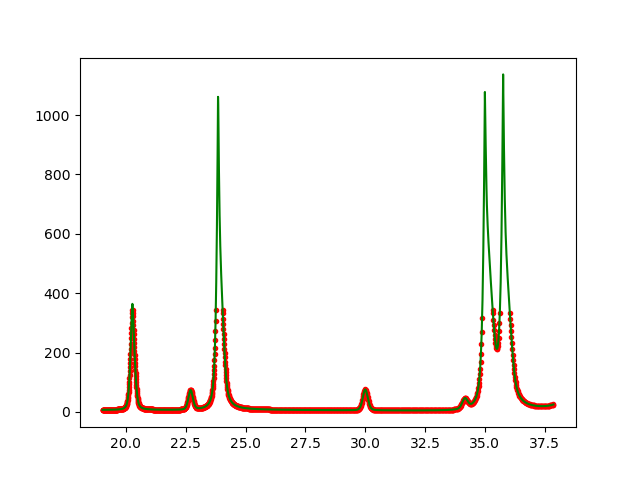

In [ ]:
from ATARI.theory.experimental import xs_2_trans, trans_2_xs
xs, _ = trans_2_xs(theo.theo_trans,0.067166)

figure()
plot(theo.E, xs, 'r.', label='theo')
plot(theo.E, theo.theo_xs, c='g', label='theo')

In [ ]:
np.array(syndat_df.tof)[np.array(syndat_df.tof)>416]

array([416.69440058, 416.79680358, 416.89920091, ..., 586.37120093,
       586.47360584, 586.57600395])

In [ ]:
import matplotlib as mplx

def correlation_from_covariance(covariance):
    v = np.sqrt(np.diag(covariance))
    outer_v = np.outer(v, v)
    correlation = covariance / outer_v
    correlation[covariance == 0] = 0
    return correlation


itof_min_jb = np.argwhere(np.array(jb_df.tof)>416)[0][0]
itof_max_jb = np.argwhere(np.array(jb_df.tof)<580)[-1][0]

jb_df_filtered = jb_df[itof_min_jb:itof_max_jb]
jb_cov_filtered = jb_cov[itof_min_jb:itof_max_jb, itof_min_jb:itof_max_jb]

itof_min = np.argwhere(np.array(syndat_df.tof)>416)[0][0]
itof_max = np.argwhere(np.array(syndat_df.tof)<580)[-1][0]

syndat_df_filtered = syndat_df[itof_min:itof_max]
syndat_cov_filtered = exp.CovT[itof_min:itof_max, itof_min:itof_max]
# syndat_cov_filtered2 = exp2.CovT[itof_min:itof_max, itof_min:itof_max]
# syndat_cov_filtered3 = exp3.CovT[itof_min:itof_max, itof_min:itof_max]

syndat_corr1 = correlation_from_covariance(syndat_cov_filtered)
# syndat_corr2 = correlation_from_covariance(syndat_cov_filtered2)
# syndat_corr3 = correlation_from_covariance(syndat_cov_filtered3)
jb_corr = correlation_from_covariance(jb_cov_filtered)


In [ ]:
# figure()
# plot(jb_df_filtered.tof, jb_df_filtered.trans, '.')
# plot(syndat_df_filtered.tof, syndat_df_filtered.trans, '.')

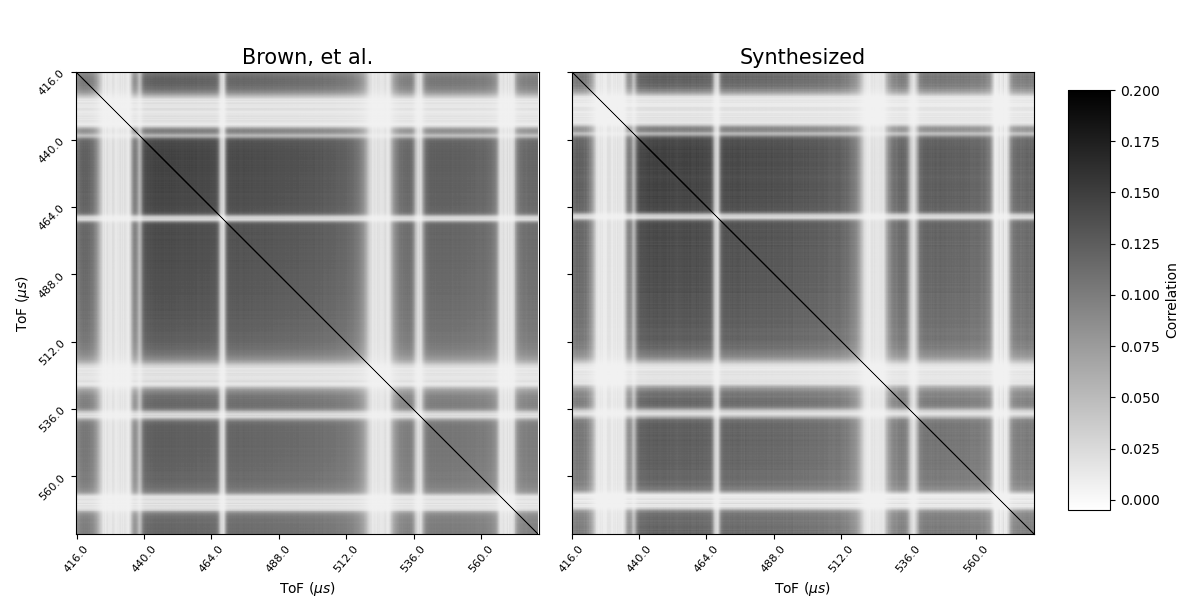

In [ ]:

import seaborn as sns


test = [jb_corr,syndat_corr1] #,syndat_corr2,syndat_corr3]

fig, axes = subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12,6))
# for i,ax in enumerate(axes.flat):
#     im = ax.imshow(test[i], vmin=-0.5, vmax=0.5, cmap='plasma')

# im = axes[0].imshow(jb_corr, vmin=-0.5, vmax=0.5, cmap='plasma')
# im = axes[1].imshow(syndat_corr1, vmin=-0.5, vmax=0.5, cmap='plasma')
im = axes[0].imshow(jb_corr, vmin=-0.005, vmax=0.2, cmap='gist_yarg')
im = axes[1].imshow(syndat_corr1, vmin=-0.005, vmax=0.2, cmap='gist_yarg')
# im = axes[1,1].imshow(syndat_corr2, vmin=-0.5, vmax=0.5, cmap='plasma')
# im = axes[0,1].imshow(syndat_corr3, vmin=-0.5, vmax=0.5, cmap='plasma')


axes[0].set_title('Brown, et al.', size=15)
# axes[0,0].set_xlabel('Index')
axes[1].set_title('Synthesized', size=15)
# axes[1,0].set_xlabel('Index')
# axes[1,1].set_title('Synthesized', size=10)
# axes[1,1].set_xlabel('Index')
# axes[0,1].set_title('Synthesized', size=10)


# suptitle('Data Correlation', size=18)
# tight_layout(pad=0.01)
fig.subplots_adjust(left=0.05, right=0.875, wspace=0, hspace=0)
cbar_ax = fig.add_axes([0.89, 0.15, 0.035, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Correlation')


for each in axes:
    each.set_xticks(np.linspace(0, len(syndat_corr1)-(len(syndat_corr1)/8),7))
    each.set_xticklabels(np.linspace(416, 560,7), fontsize=8, rotation=50)    
    each.set_yticks(np.linspace(0, len(syndat_corr1)-(len(syndat_corr1)/8),7))
    each.set_yticklabels(np.linspace(416, 560,7), fontsize=8, rotation=45)
    each.set_xlabel(r'ToF $(\mu s)$')
    
axes[0].set_ylabel(r'ToF $(\mu s)$')
fig.savefig("/Users/noahwalton/Library/Mobile Documents/com~apple~CloudDocs/Research Projects/Resonance Fitting/Syndat Paper/CPC_Manuscript_Walton_2023/Syndat_vs_Brown_journal_Corr_new.png")
# fig.supxlabel('ToF')
# tight_layout()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


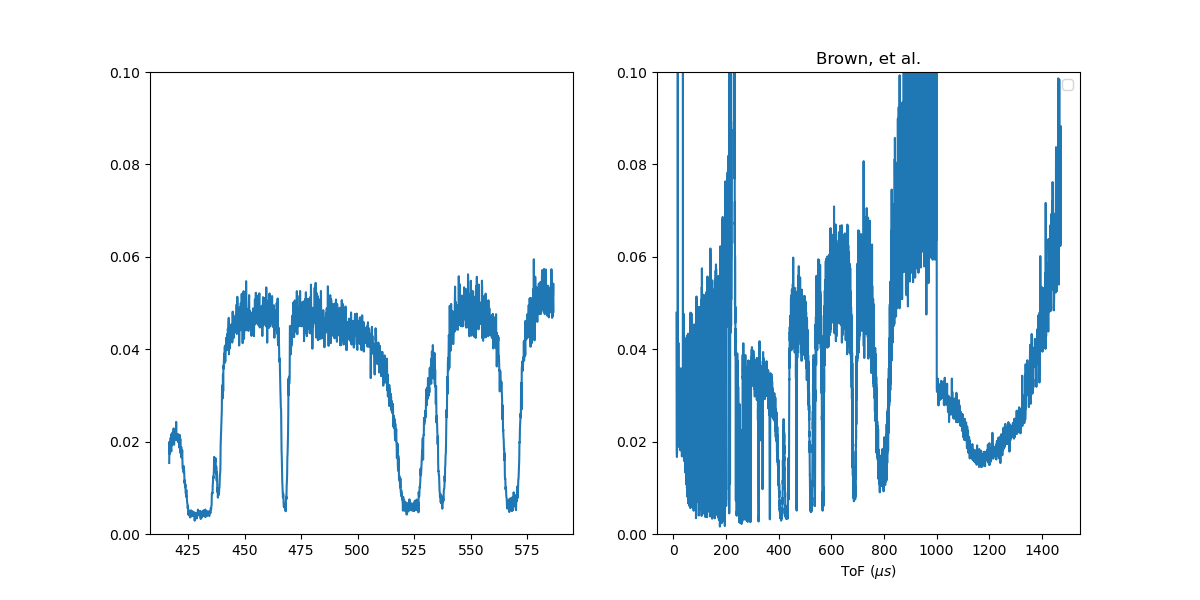

In [ ]:
fig,ax = subplots(1,2, figsize=(12,6))

# ax[0].plot(syndat_df.tof, np.sqrt(np.diag(exp.CovT_sys+exp.CovT_stat)))
ax[0].plot(syndat_df.tof, np.sqrt(np.diag(exp.CovT)))
ax[0].set_ylim([0,0.1])

ax[1].plot(jb_df.tof,np.sqrt(np.diag(jb_cov)))
ax[1].set_ylim([0,0.1])
# ax[1].set_xlim([214,1e3])

ax[1].set_title('Brown, et al.')
ax[1].legend(loc='upper right')
ax[1].set_xlabel('ToF ($\mu s$)')
# ax[1].set_ylabel('Relative Std')
ax[1].legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(185.0, 215.0)

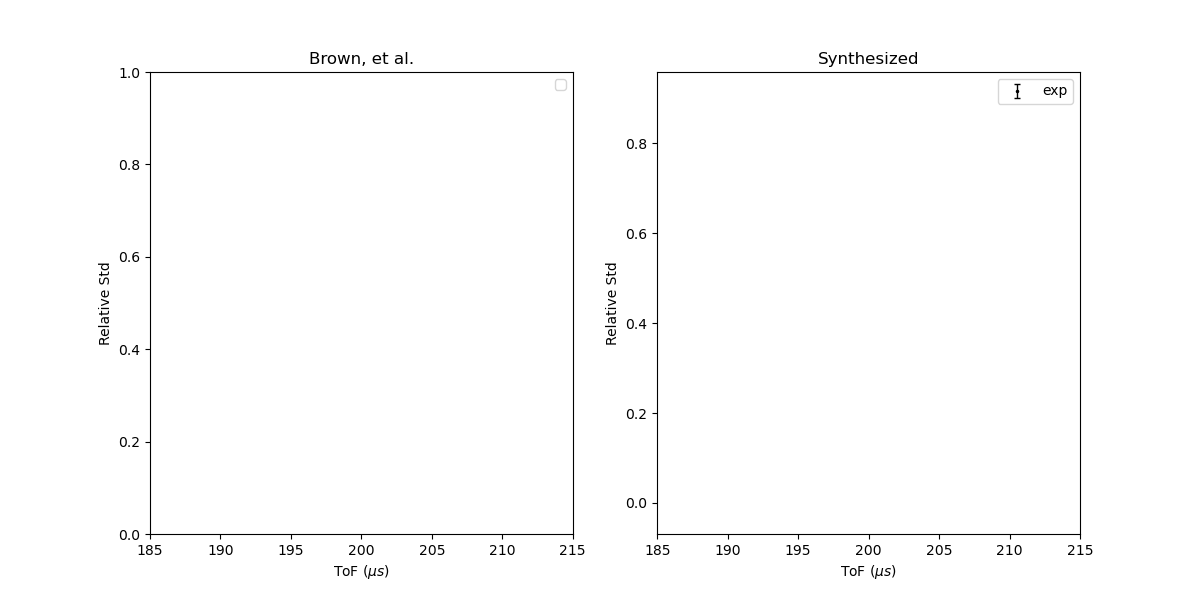

In [ ]:

fig,ax = subplots(1,2, figsize=(12,6))
# suptitle('Theoretical and experimental transmission')

# ax[1].plot(syndat_df.tof,syndat_df.theo*.97, lw=2,c='b', label='est', zorder=2)
# ax[1].plot(syndat_df.tof,syndat_df.theo*.97+.1, lw=2,c='r', label='est std', zorder=2)
# lower =syndat_df.theo*.97-.07
# lower = np.where(lower<0, 0, lower)
# ax[1].plot(syndat_df.tof,lower, lw=2,c='r', zorder=2)

# ax[1].plot(theo.tof,syndat_df.theo, lw=2,c='g', label='true', zorder=2)

# ax[1].scatter(theo.tof,theo.theo_trans, marker='.', s=5, c='k', label='exp')
ax[1].errorbar(syndat_df.tof, syndat_df.trans, yerr=exp.trans.exp_trans_unc, color='k',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3, zorder=1, label='exp')
# ax[1].scatter(syndat_df.tof, np.sqrt(np.diag(syndat_cov))/syndat_df.trans, marker='.', color='b', s=5)
# ax[1].plot(syndat_df.tof, np.sqrt(np.diag(jb_cov))-experiment.trans.exp_trans_unc)
# ax[1].plot(syndat_df.tof, jb_df.trans-syndat_df.trans)
# ax[1].set_yscale('log')
# ax[1].set_ylim([-0.1,1])
# ax[1].axhline(y=0.0, ls='--')
# ax[1
#].fill_between([0,54], [-0.05,1], alpha=0.4, color='k', label='URR')

ax[1].set_title("Synthesized")
ax[1].legend(loc='upper right')
ax[1].set_xlabel('ToF ($\mu s$)')
ax[1].set_ylabel('Relative Std')
ax[1].legend()




# ax[0].plot(syndat_df.tof,syndat_df.theo, lw=2,c='g', label='theo', zorder=2)
# ax[0].scatter(syndat_df.tof,syndat_df.trans, marker='.', s=5, c='r', label='exp')
# ax[0].scatter(jb_df.tof, jb_df.trans, marker='.', color='k', s=5, label='exp')
# ax[0].errorbar(jb_df.tof, jb_df.trans, yerr=np.sqrt(np.diag(jb_cov)), color='k',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3, zorder=1)
# ax[0].scatter(jb_df.tof, np.sqrt(np.diag(jb_cov))/jb_df.trans, marker='.', color='b', s=5)
# ax[0].errorbar(JBrown_lst.tof, JBrown_lst.exp_trans, yerr=JBrown_lst.exp_trans_unc, color='k',ecolor='k',elinewidth=1,capsize=2, fmt='.', ms=3)
# ax[0].set_yscale('log')
# ax[0].axhline(y=0.0, ls='--')
# ax[0].set_ylim([1e-2,1e2])
# ax[0].fill_between([0,54], [-0.05,1], alpha=0.4, color='k', label='URR')

ax[0].set_title('Brown, et al.')
ax[0].legend(loc='upper right')
ax[0].set_xlabel('ToF ($\mu s$)')
ax[0].set_ylabel('Relative Std')
ax[0].legend()



# ax[0].set_xlim([10,3e3])
# ax[1].set_xlim([10,3e3])


# ax[1].set_xticks(np.array([185, 195, 205, 215]), minor=False)
# ax[0].set_xticks(np.linspace(185,215, 1), minor=False)
ax[0].set_xlim([185,215])
ax[1].set_xlim([185,215])

# ax[1].set_xlim([145,185])
# ax[0].set_xlim([145,185])
# syndat.exp_effects.e_to_t(144, 35, True)*1e6

In [ ]:
# a_expdat_df = pd.DataFrame({'E':jb_df.e, 'expT':jb_df.trans, 'dT':np.sqrt(np.diag(jb_cov))})
# syndat.sammy_interface.write_expdat_file(a_expdat_df, "/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/bayes_solve/real.dat")

## Compare covariance matrix to Jesse's

This will give insight into whether or not the monitor normalizations have an effect

In [ ]:
# import jesse's covariance 
jb_cov = np.load('/Users/noahwalton/research_local/resonance_fitting/synthetic_data/Ta181/JB_sol/JB_cov.npy')
syndat_cov = exp.CovT
print(np.shape(syndat_cov))
print(np.shape(jb_cov))


(1660, 1660)
(15915, 15915)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


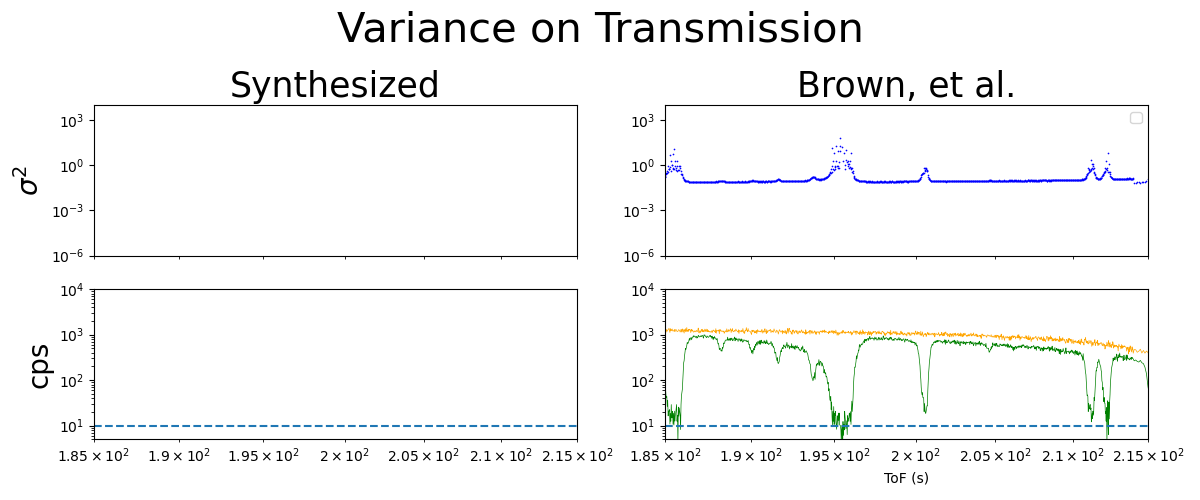

In [ ]:
fig, (ax1, ax2) = subplots(2,2, gridspec_kw={'height_ratios': [1, 1]}, sharex=True, figsize=(12,5)) # , figsize=(12,5)

ax1[0].scatter(syndat_df.tof, np.sqrt(np.diag(syndat_cov))/syndat_df.trans, lw=0.5, color='b', s=0.5, zorder=2)
ax1[0].set_ylim([1e-6,1e4])
ax1[0].set_xlim([50,1.5e3])
ax1[0].set_yscale('log')
ax1[0].set_title('Synthesized', size=25)
ax1[0].set_ylabel('$\sigma^2$', size=20); #('$\sigma$')

ax2[0].plot(syndat_df.tof, syndat_df.co, lw=0.5, c='orange')
ax2[0].plot(syndat_df.tof, syndat_df.cs, lw=0.5, c='g')
ax2[0].set_ylim([5,1e4])
ax2[0].axhline(y=10.0, ls='--')
ax2[0].set_ylabel('cps', size=20)
ax2[0].set_yscale('log')


ax1[1].scatter(jb_df.tof, np.sqrt(np.diag(jb_cov))/jb_df.trans, lw=0.5, color='b', s=0.5, zorder=2)
ax1[1].set_yscale('log')
ax1[1].set_ylim([1e-6,1e4])
ax1[1].set_xlim([50,1.5e3])
# ax1[1].set_ylabel('$\sigma^2$')
ax1[1].set_title('Brown, et al.', size=25)
ax1[1].legend()

ax2[1].plot(jb_df.tof, jb_df.co, lw=0.5, c='orange')
ax2[1].plot(jb_df.tof, jb_df.cs, lw=0.5, c='g')
ax2[1].set_ylim([5,1e4])
ax2[1].axhline(y=10.0, ls='--')
# ax2[1].set_ylabel('cps')
ax2[1].set_yscale('log')

ax2[0].set_xlim([185,215])
ax2[1].set_xlim([185,215])

xscale('log')
xlabel('ToF (s)');
suptitle('Variance on Transmission',size=30)
tight_layout()


In [ ]:
# figure()
# plot(jb_df.tof, (np.diag(syndat_cov)-np.diag(jb_cov))/np.diag(jb_cov))

# ylim([-2,20])
# xscale('log')
# # print(len(jb_df.tof))
# # print(len(syndat_df.tof))

In [ ]:



itof_min = np.argwhere(np.array(syndat_df.tof)>185)[0][0]
itof_max = np.argwhere(np.array(syndat_df.tof)<215)[-1][0]
jb_df_filtered = jb_df[itof_min:itof_max]
syndat_df_filtered = syndat_df[itof_min:itof_max]

jb_cov_filtered = jb_cov[itof_min:itof_max, itof_min:itof_max]
syndat_cov_filtered = syndat_cov[itof_min:itof_max, itof_min:itof_max]
print(np.shape(syndat_cov_filtered))
print(np.shape(jb_cov_filtered)) 

syndat_corr = correlation_from_covariance(syndat_cov_filtered)
jb_corr = correlation_from_covariance(jb_cov_filtered)


fig =figure(figsize=(12,6))

vmin = -0.5; vmax = 0.5

ax1 = fig.add_subplot(122)
mesh1 = ax1.imshow(syndat_corr, cmap ='plasma')
mesh1.set_clim(vmin, vmax)
ax1.set_title('Synthesized')

ax2 = fig.add_subplot(121)
mesh2 = ax2.imshow(jb_corr, cmap ='plasma')
mesh2.set_clim(vmin, vmax)
ax2.set_title("Brown, et. al")


fig.colorbar(mesh1,ax=ax1)
fig.colorbar(mesh2,ax=ax2)


IndexError: index -1 is out of bounds for axis 0 with size 0

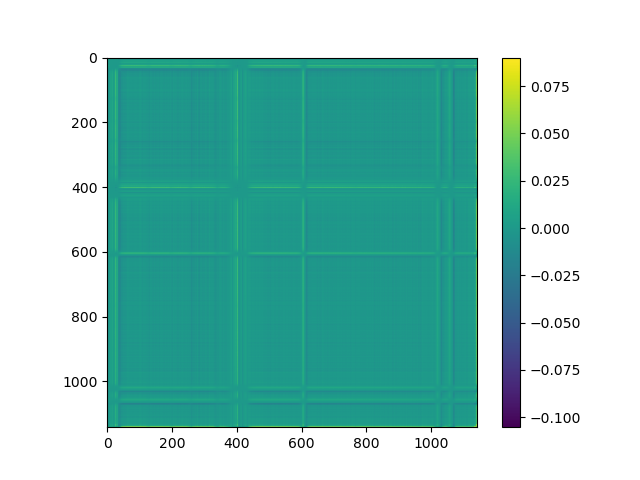

In [ ]:
figure()
# imshow((jb_cov_filtered-syndat_cov_filtered))
imshow((jb_corr-syndat_corr))
colorbar()



In [ ]:
# np.shape(jb_evec)
print(np.argwhere((jb_corr-syndat_corr) == max(((jb_corr-syndat_corr)).max(axis=1))))
print((jb_corr)[74,465])
print((syndat_corr)[74,465])

[[1133  402]]
0.08937177404795207
0.09197851298971699


In [ ]:
# figure()
# plot(jb_df_filtered.tof, jb_evec[0])
# plot(syndat_df_filtered.tof, syndat_evec[0])
# # xscale('log')
# yscale('log')